In [41]:
suppressPackageStartupMessages(library(SoupX))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(DropletUtils))
suppressPackageStartupMessages(library(ggExtra))

In [2]:
data_path <- "../data_dir/GSM5740435_S5.raw_matrix.h5"
scd = Seurat::Read10X_h5(data_path, use.names = TRUE, unique.features = TRUE) # single-cell-data
scd = scd[, colSums2(scd) > 0]

In [9]:
br.out <- barcodeRanks(scd)

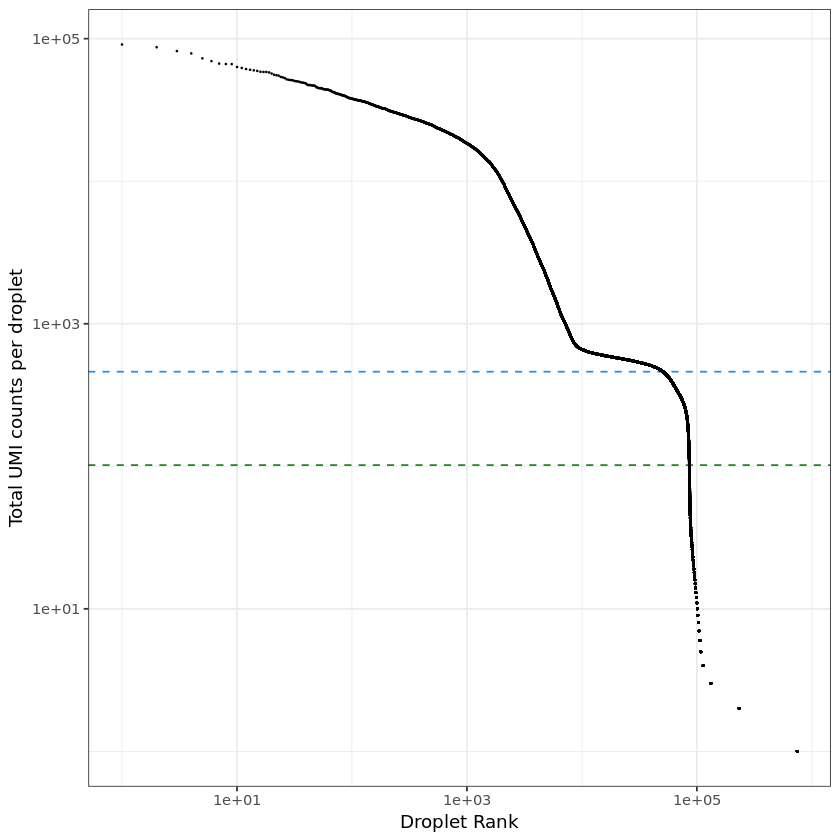

In [10]:
ggplot(br.out, aes(x = rank, y= total)) +
  scale_x_log10() +
  scale_y_log10() +
  geom_hline(yintercept = metadata(br.out)$knee, color="dodgerblue",linetype=2) +
  geom_hline(yintercept = metadata(br.out)$inflection, color="forestgreen",linetype=2) +
  geom_point(size = 0.1) +
  labs(y = "Total UMI counts per droplet", x="Droplet Rank", "QC for Empty Droplets") +
  theme_bw()

In [11]:
e.out <- emptyDrops(scd)

In [58]:
e.out[!is.na(e.out$LogProb), "p_adj"] <- p.adjust(e.out[!is.na(e.out$LogProb),]$PValue, method = "BH")

In [60]:
e.out$is.cell <- e.out$p_adj <= 0.01
sum(e.out$is.cell, na.rm=TRUE)
summary(e.out[is.na(e.out$LogProb),])

[1] 9852

[1] "DataFrame object of length 7 with 0 metadata columns"

In [61]:
e.out[is.na(e.out$LogProb),]$is.cell <- FALSE

In [62]:
str(e.out[!is.na(e.out$LogProb),])

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:86031] "AAACCCAAGAACGCGT-1" "AAACCCAAGAATTGTG-1" "AAACCCAAGACGCATG-1" "AAACCCAAGAGGCGTT-1" ...
  ..@ nrows          : int 86031
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       :List of 5
  .. ..$ lower  : num 100
  .. ..$ niters : num 10000
  .. ..$ ambient: num [1:24190, 1] 3.90e-05 1.04e-04 4.13e-05 1.21e-03 1.35e-03 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:24190] "InfluenzaA_PB2" "InfluenzaA_PB1" "InfluenzaA_PA" "InfluenzaA_HA" ...
  .. .. .. ..$ : NULL
  .. ..$ alpha  : num 1232
  .. ..$ retain : num 461
  ..@ listData       :List of 7
  .. ..$ Total  : int [1:86031] 554 658 634 419 226 183 569 239 677 567 ...
  .. ..$ LogProb: num [1:86031] -1310 -1492 -1567 -1037 -709 ...
  .. ..$ PValue : num [1:86031] 0.2939 0.1327 0.0003 0.8032 0.2808 ...
  .. ..$ Limited: logi [1:86031] FALSE FALSE FALSE FALSE FALSE FALSE ...
  .. ..$ FDR    : n

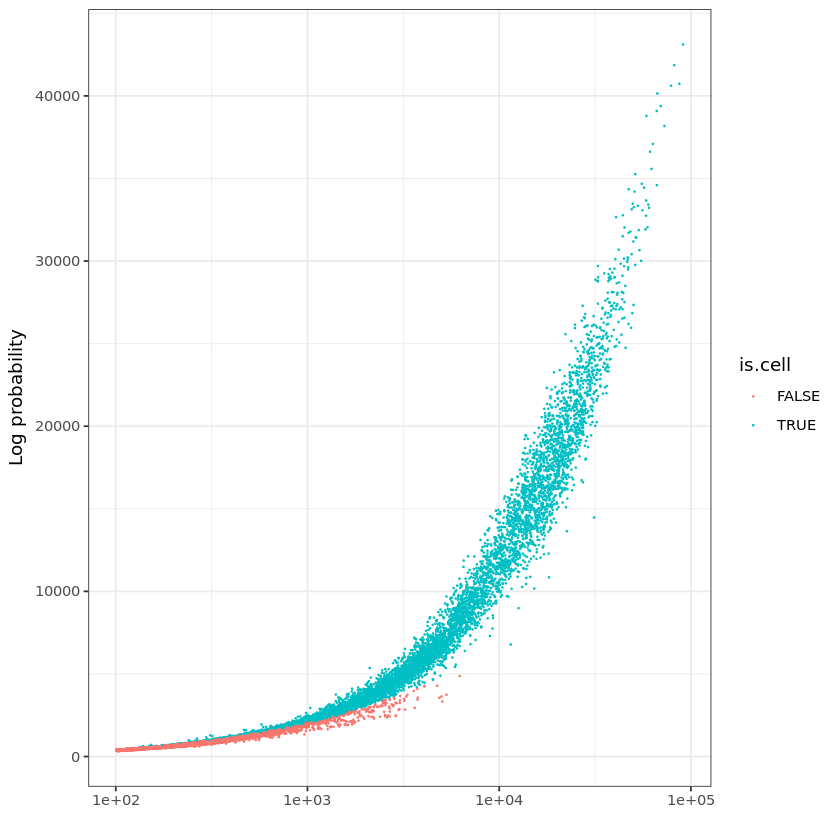

In [63]:
ggplot(e.out[!is.na(e.out$LogProb),], aes(x = Total, y= -LogProb, color = is.cell)) +
  scale_x_log10() +
  geom_point(size = 0.1) +
  labs(y = "Log probability", x="", "QC for Cell calling") +
  theme_bw()

In [64]:
str(e.out)

Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  ..@ rownames       : chr [1:1171726] "AAACCCAAGAAACCCA-1" "AAACCCAAGAAACCCG-1" "AAACCCAAGAAACGAA-1" "AAACCCAAGAAACTAC-1" ...
  ..@ nrows          : int 1171726
  ..@ elementType    : chr "ANY"
  ..@ elementMetadata: NULL
  ..@ metadata       :List of 5
  .. ..$ lower  : num 100
  .. ..$ niters : num 10000
  .. ..$ ambient: num [1:24190, 1] 3.90e-05 1.04e-04 4.13e-05 1.21e-03 1.35e-03 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:24190] "InfluenzaA_PB2" "InfluenzaA_PB1" "InfluenzaA_PA" "InfluenzaA_HA" ...
  .. .. .. ..$ : NULL
  .. ..$ alpha  : num 1232
  .. ..$ retain : num 461
  ..@ listData       :List of 7
  .. ..$ Total  : int [1:1171726] 2 1 1 1 1 1 1 1 1 554 ...
  .. ..$ LogProb: num [1:1171726] NA NA NA NA NA ...
  .. ..$ PValue : num [1:1171726] NA NA NA NA NA ...
  .. ..$ Limited: logi [1:1171726] NA NA NA NA NA NA ...
  .. ..$ FDR    : num [1:1171726] NA NA NA NA NA NA NA NA NA 0 ...
  .. ..$ i

In [99]:
so = CreateSeuratObject(counts = scd[, e.out$is.cell]) # seurat object
so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


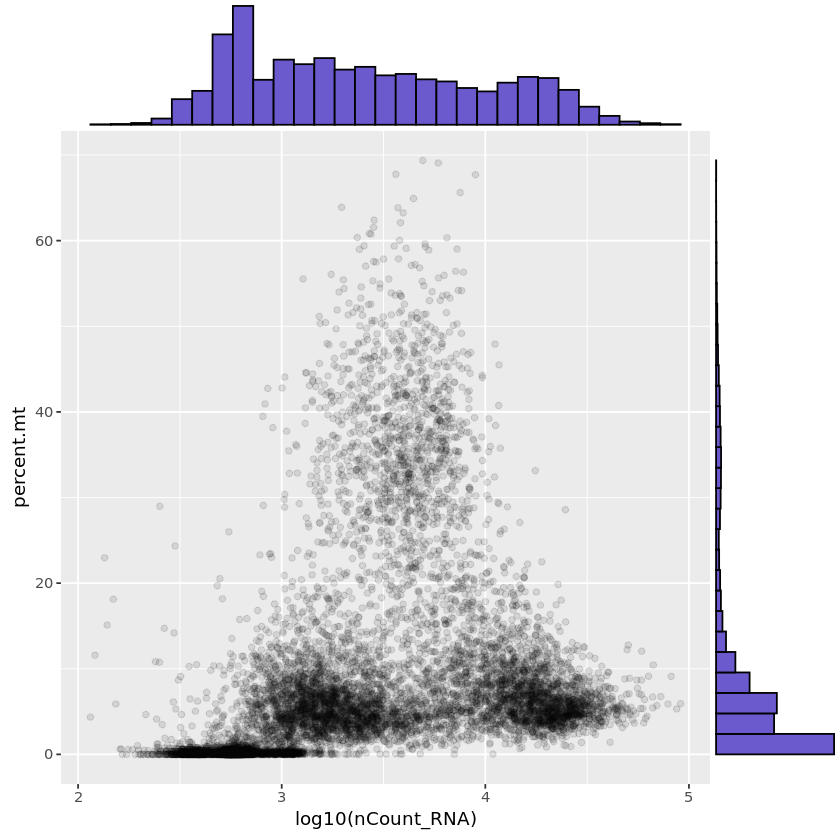

In [101]:
p <- ggplot(so@meta.data, aes(log10(nCount_RNA), percent.mt)) + geom_point(alpha = 0.1)
p2 <- ggMarginal(p, type="histogram", fill = "slateblue")
p2

In [102]:
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



In [103]:
so <- FindVariableFeatures(so, selection.method = "vst", nfeatures = 2000)


Finding variable features for layer counts



In [104]:
so <- ScaleData(so, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



In [105]:
so <- RunPCA(so, features = VariableFeatures(object = so))

PC_ 1 
Positive:  S100A2, KRT6A, KRT5, MT2A, KRT17, KRT14, S100A8, S100A9, MT1X, COL17A1 
	   FABP5, FGFBP1, GJB2, TNC, FLNA, COL7A1, CAV1, FGFR3, LDHA, SERPINB3 
	   LAMA3, MIR205HG, CD44, ATP1B3, ITGA6, S100A14, ITGA3, S100A10, FST, TUBA4A 
Negative:  LRRIQ1, CAPS, TMC5, C20orf85, CCDC170, RRAD, SNTN, PIFO, RSPH1, RSPH4A 
	   DNALI1, ZMYND10, C5orf49, TPPP3, C9orf24, ERICH3, DNAAF1, C9orf116, AGR3, TMEM190 
	   CFAP126, FAM92B, ROPN1L, SAA2, ODF3B, TUBA1A, MORN2, FAM81B, CD74, C1orf194 
PC_ 2 
Positive:  MT2A, S100A2, KRT5, KRT14, KRT17, C20orf85, TUBA1A, CAPS, TPPP3, DNAAF1 
	   C9orf24, RRAD, ROPN1L, PIFO, LRRIQ1, SNTN, AC007906.2, ERICH3, C1orf194, C5orf49 
	   ZMYND10, FAM92B, SYNE1, DNAH12, RSPH1, CAPSL, RP1, S100A10, TMEM190, CDHR3 
Negative:  AQP5, ATP1B1, CCND1, CD55, CEACAM6, XBP1, ALDH1A3, KLF5, PI3, CP 
	   KRT7, MUC1, KLF6, FAM3D, F3, RDH10, SOX4, CYP2B7P, LMO4, CEACAM5 
	   GABRP, SLC6A14, AGR2, GPRC5A, SPRR3, CXCL17, JUN, S100P, ALDH1A1, SGK1 
PC_ 3 
Positive:  COL17A1,

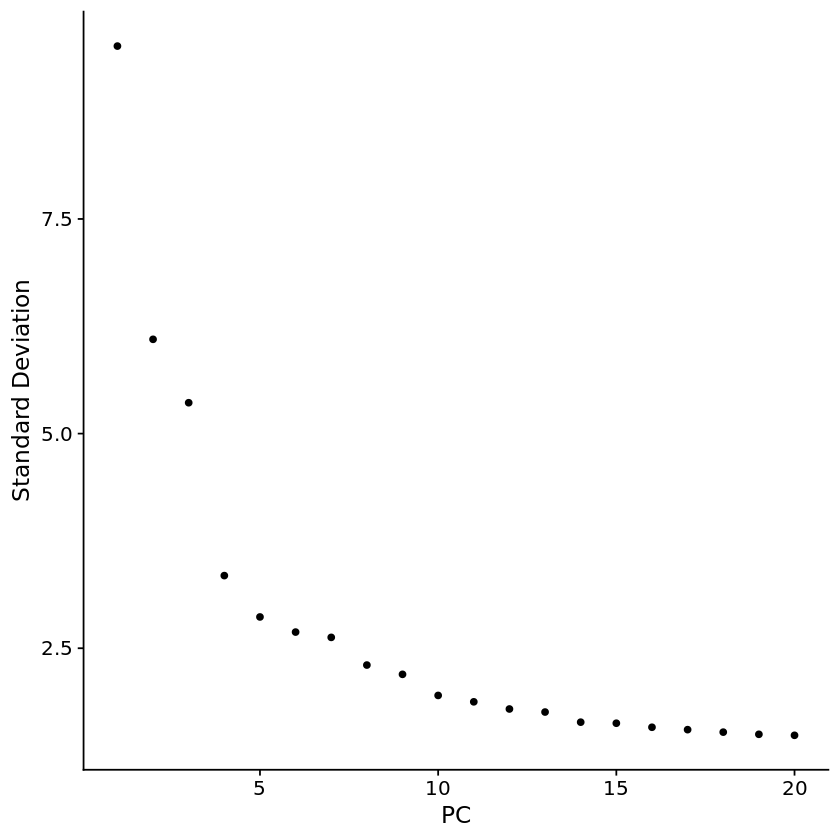

In [106]:
ElbowPlot(so)

In [107]:
so <- FindNeighbors(so)
so <- FindClusters(so, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9852
Number of edges: 305629

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8789
Number of communities: 12
Elapsed time: 1 seconds


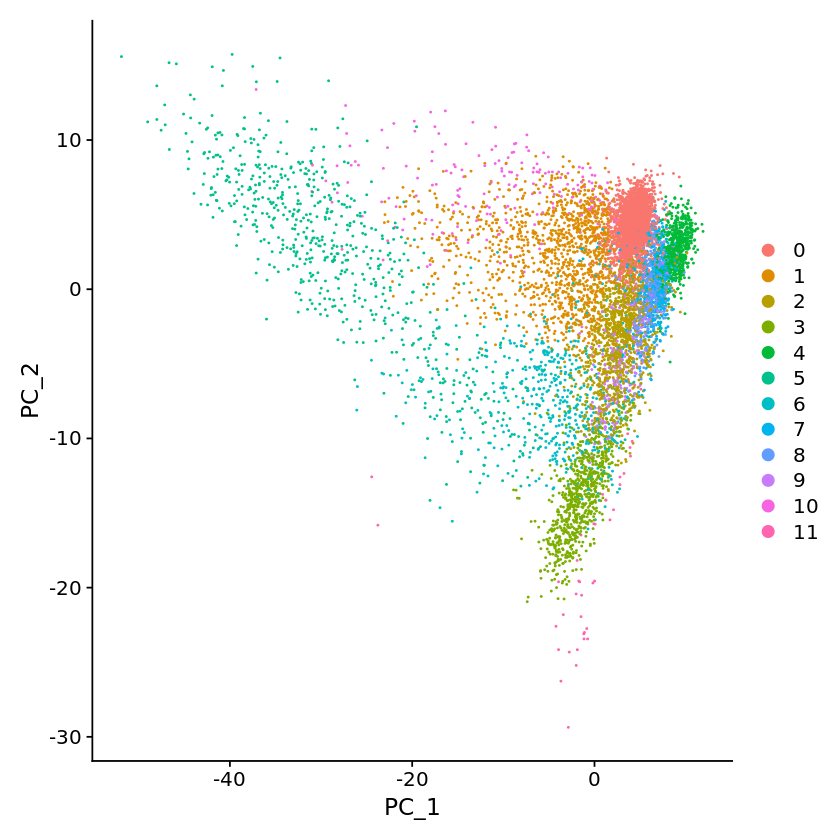

In [108]:
DimPlot(so, reduction = "pca")

In [109]:
so <- RunUMAP(so, dims = 1:15)

07:19:37 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

07:19:37 Read 9852 rows and found 15 numeric columns

07:19:37 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

07:19:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

07:19:38 Writing NN index file to temp file /tmp/Rtmp7M17bs/file93b366fb417

07:19:38 Searching Annoy index using 1 thread, search_k = 3000

07:19:40 Annoy recall = 100%

07:19:43 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

07:19:47 Initializing from normalized Laplacian + no

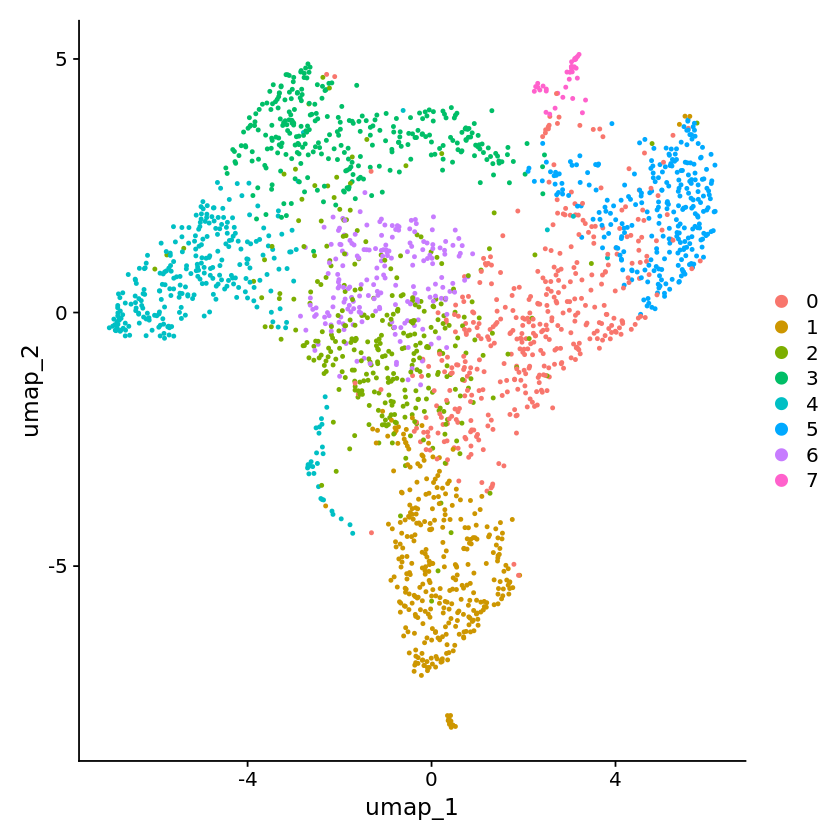

In [218]:
DimPlot(so, reduction = "umap")

In [94]:
sc = SoupChannel(scd, scd[, e.out$is.cell], calcSoupProfile = FALSE)
sc = estimateSoup(sc)


In [111]:
seurat_clusters <- as.integer(so@meta.data$seurat_clusters)
names(seurat_clusters) <- rownames(so@meta.data)

In [112]:
str(seurat_clusters)

 Named int [1:9852] 1 3 5 1 9 1 3 5 6 5 ...
 - attr(*, "names")= chr [1:9852] "AAACCCAAGACGCATG-1" "AAACCCACAGATCCTA-1" "AAACCCACAGCGTAGA-1" "AAACCCACAGTCGAGA-1" ...


In [113]:
str(scd[, e.out$is.cell])

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:16488837] 69 115 125 228 240 477 478 534 567 658 ...
  ..@ p       : int [1:9853] 0 428 1814 4330 4961 6899 7518 8773 11161 15983 ...
  ..@ Dim     : int [1:2] 43027 9852
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:43027] "InfluenzaA_PB2" "InfluenzaA_PB1" "InfluenzaA_PA" "InfluenzaA_HA" ...
  .. ..$ : chr [1:9852] "AAACCCAAGACGCATG-1" "AAACCCACAGATCCTA-1" "AAACCCACAGCGTAGA-1" "AAACCCACAGTCGAGA-1" ...
  ..@ x       : num [1:16488837] 3 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()


In [114]:
sc <- setClusters(sc, seurat_clusters)

1671 genes passed tf-idf cut-off and 868 soup quantile filter.  Taking the top 100.

Using 516 independent estimates of rho.

Estimated global rho of 0.04



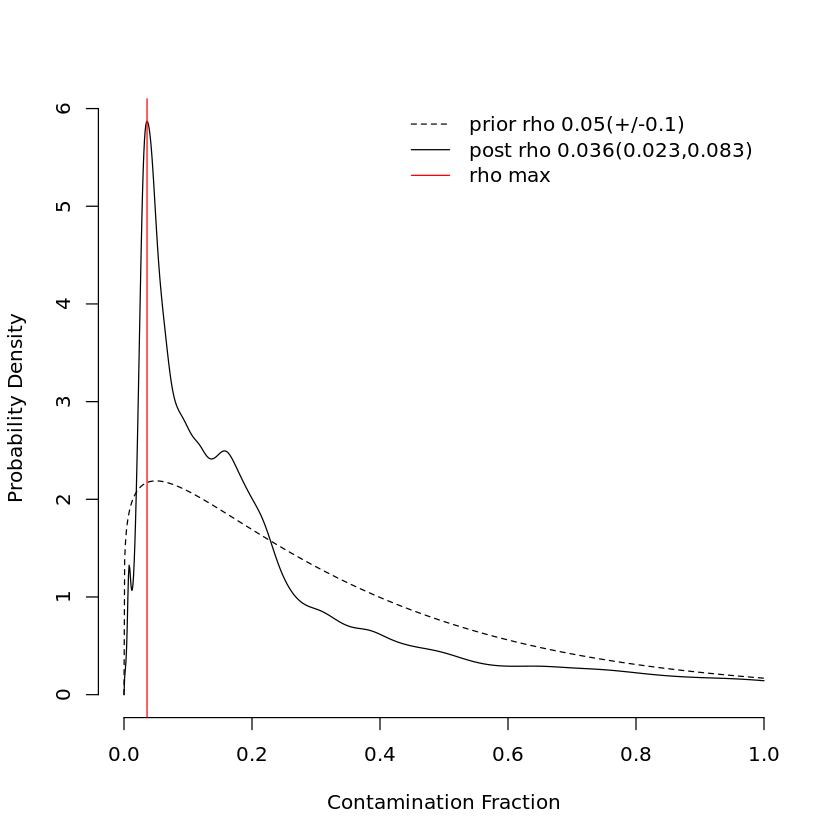

In [115]:
sc = autoEstCont(sc)

In [118]:
str(so@reductions$umap@cell.embeddings)

 num [1:9852, 1:2] -2.32 1.98 -5.98 -2.25 -1.86 ...
 - attr(*, "scaled:center")= num [1:2] 0.227 1.523
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:9852] "AAACCCAAGACGCATG-1" "AAACCCACAGATCCTA-1" "AAACCCACAGCGTAGA-1" "AAACCCACAGTCGAGA-1" ...
  ..$ : chr [1:2] "umap_1" "umap_2"


In [126]:
str(sc)

List of 6
 $ toc        :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:16488837] 69 115 125 228 240 477 478 534 567 658 ...
  .. ..@ p       : int [1:9853] 0 428 1814 4330 4961 6899 7518 8773 11161 15983 ...
  .. ..@ Dim     : int [1:2] 43027 9852
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:43027] "InfluenzaA_PB2" "InfluenzaA_PB1" "InfluenzaA_PA" "InfluenzaA_HA" ...
  .. .. ..$ : chr [1:9852] "AAACCCAAGACGCATG-1" "AAACCCACAGATCCTA-1" "AAACCCACAGCGTAGA-1" "AAACCCACAGTCGAGA-1" ...
  .. ..@ x       : num [1:16488837] 3 1 1 1 1 1 1 1 1 1 ...
  .. ..@ factors : list()
 $ metaData   :'data.frame':	9852 obs. of  5 variables:
  ..$ nUMIs   : num [1:9852] 634 3091 6478 1195 6236 ...
  ..$ clusters: chr [1:9852] "1" "3" "5" "1" ...
  ..$ rho     : num [1:9852] 0.036 0.036 0.036 0.036 0.036 0.036 0.036 0.036 0.036 0.036 ...
  ..$ umap_1  : num [1:9852] -2.32 1.98 -5.98 -2.25 -1.86 ...
  ..$ umap_2  : num [1:9852] 3.083 -3.62 -1.361 0.501 -3.723 ...
 $ nDr

In [127]:
out = adjustCounts(sc)

Warning message in sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w], :
"'giveCsparse' is deprecated; setting repr="T" for you"
Expanding counts from 12 clusters to 9852 cells.



In [135]:
so <- CreateSeuratObject(out)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [136]:
so[["percent.Flu"]] <- PercentageFeatureSet(so, pattern = "^Influ")
so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")

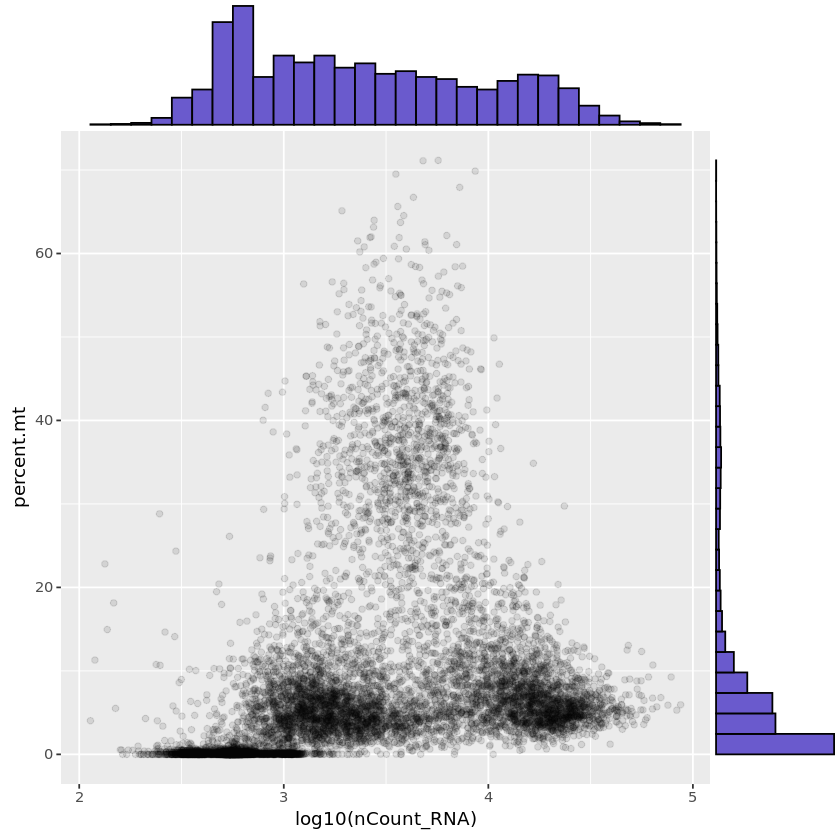

In [137]:
p <- ggplot(so@meta.data, aes(log10(nCount_RNA), percent.mt)) + geom_point(alpha = 0.1)
p2 <- ggMarginal(p, type="histogram", fill = "slateblue")
p2

[1] 2167

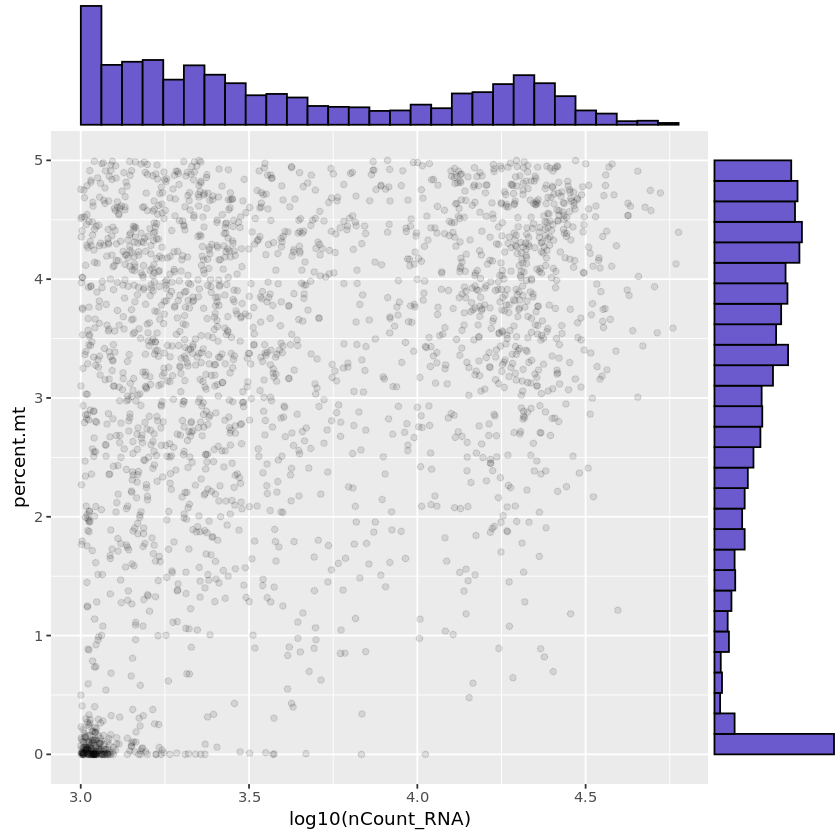

In [167]:
filtered = subset(so@meta.data, percent.mt < 5 & nCount_RNA > 1000)
nrow(filtered)
p <- ggplot(filtered, aes(log10(nCount_RNA), percent.mt)) + geom_point(alpha = 0.1)
p2 <- ggMarginal(p, type="histogram", fill = "slateblue")
p2

In [169]:
so <- subset(so, subset = percent.mt < 5 & nCount_RNA > 1000)


In [170]:
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- FindVariableFeatures(so, selection.method = "vst", nfeatures = 2000)
so <- ScaleData(so, vars.to.regress = "percent.mt")

Normalizing layer: counts

Finding variable features for layer counts

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
"Different features in new layer data than already exists for scale.data"


In [171]:
so <- RunPCA(so, features = VariableFeatures(object = so))

PC_ 1 
Positive:  SAT1, LCN2, SAA2, TSPAN1, KRT7, ANXA1, LYPD2, SAA1, TMC5, SLPI 
	   CAPS, C20orf85, ELF3, SNTN, WFDC2, PIFO, PIGR, PSCA, RSPH1, C5orf49 
	   CD74, TPPP3, HLA-DRA, LGALS3, RRAD, SLC44A4, TUBA1A, KRT8, C9orf116, ROPN1L 
Negative:  KRT6A, KRT5, KRT17, MT2A, CAV1, MT1X, S100A10, SFN, FABP5, ITGA6 
	   COL17A1, MIR205HG, GJB2, KRT14, FGFBP1, TUBA1B, PDPN, CAVIN1, TUBB, FST 
	   TUBA4A, DST, LDHB, PLP2, ATP1B3, TUBB6, EMP3, LAMA3, ITGB1, FSCN1 
PC_ 2 
Positive:  IGFBP7, C20orf85, PIFO, TUBA1A, RSPH1, SNTN, C5orf49, CAPS, CFAP126, FAM92B 
	   TPPP3, C9orf116, BASP1, ROPN1L, RRAD, ZMYND10, C9orf24, WDR54, C1orf194, S100A10 
	   C9orf135, DNALI1, C11orf88, CAPSL, MORN2, RSPH4A, TEKT1, FAM81B, AC007906.2, LRRIQ1 
Negative:  SLPI, AQP5, AGR2, SERPINB3, SPRR3, KRT7, S100A9, BPIFA1, CEACAM6, S100P 
	   BPIFB1, PI3, CD55, FAM3D, LYPD2, CXCL17, CEACAM5, WFDC2, VMO1, LCN2 
	   CYP2B7P, CP, XBP1, SPRR2A, S100A4, GABRP, ANXA1, LGALS3, MSMB, SPRR1B 
PC_ 3 
Positive:  CRCT1, TMPRSS11E, I

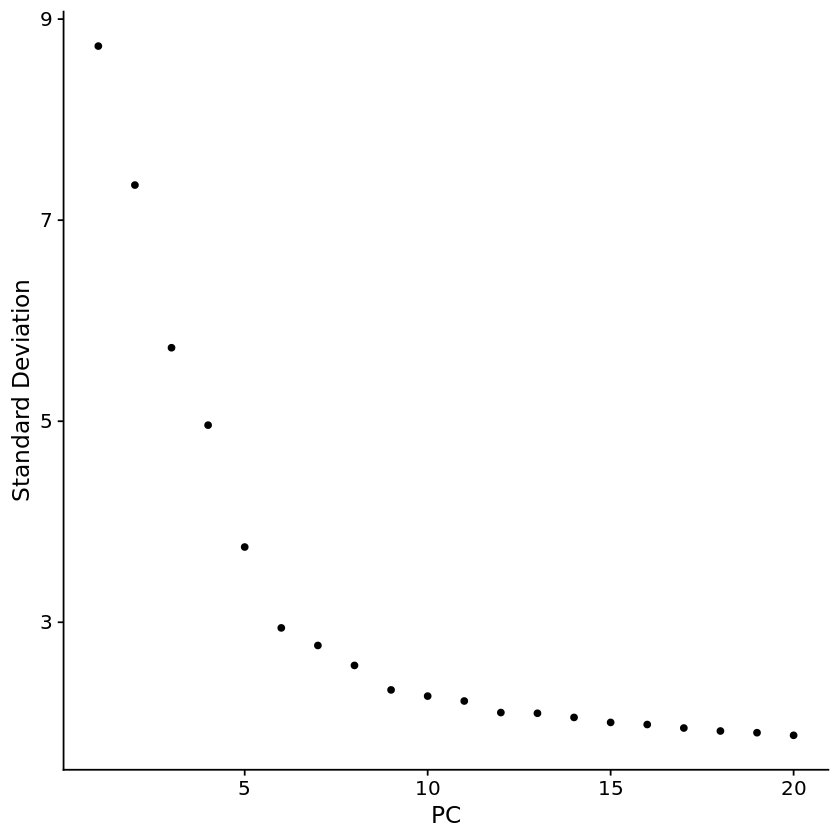

In [172]:
ElbowPlot(so)

In [173]:
so <- FindNeighbors(so)
so <- FindClusters(so, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2167
Number of edges: 71518

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8341
Number of communities: 8
Elapsed time: 0 seconds


In [235]:
so <- RunUMAP(so, dims = 1:10, verbose = F)

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'



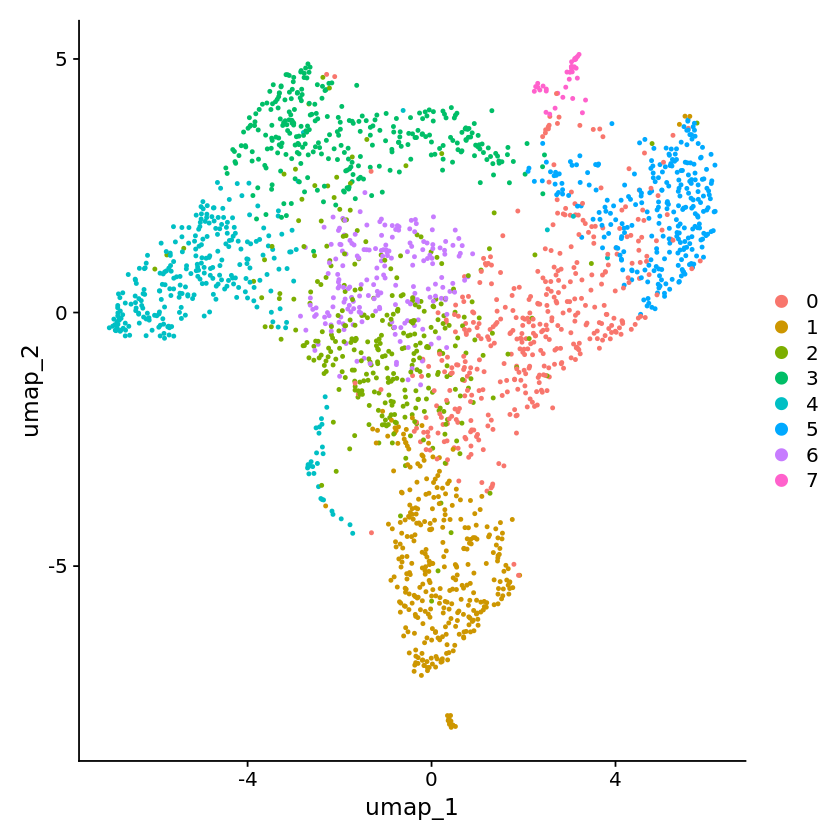

In [236]:
DimPlot(so, reduction = "umap")

In [233]:
so <- RunTSNE(so, dims = 1:15, resolution=5)

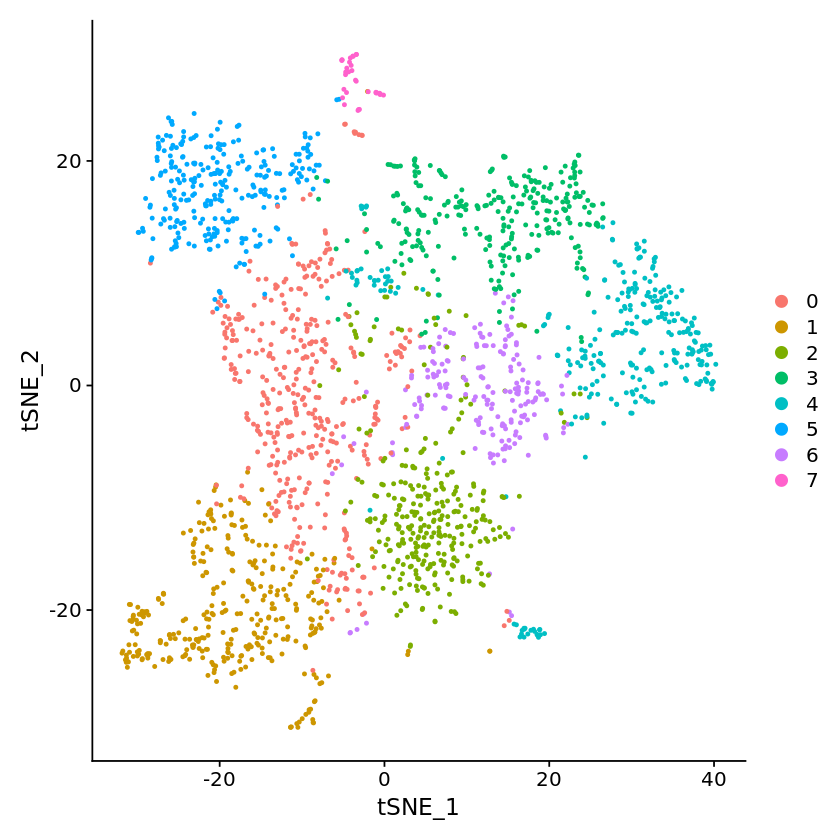

In [234]:
DimPlot(so, reduction = "tsne")

In [183]:
so.markers <- FindAllMarkers(so)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7



In [184]:
head(so.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SLPI,2.141363e-81,0.8266207,1.000,0.998,9.213641e-77,0,SLPI
WFDC2,1.509325e-72,0.8020673,1.000,0.987,6.494171e-68,0,WFDC2
BPIFA1,1.479769e-65,1.0645860,0.990,0.686,6.367001e-61,0,BPIFA1
BPIFB1,5.766803e-58,1.1417667,0.935,0.619,2.481282e-53,0,BPIFB1
LYPD2,1.197944e-54,0.9913838,0.949,0.633,5.154396e-50,0,LYPD2
AQP5,1.755862e-54,1.1741597,0.824,0.445,7.554948e-50,0,AQP5


Warning message in DoHeatmap(so, features = top10$gene):
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: ELF1, JAK1, MT-RNR2, S100A2, MT-ND1, MT-ATP6, MT-CYB, MT-ND3, MT-CO3, MT-CO1, MT-CO2"


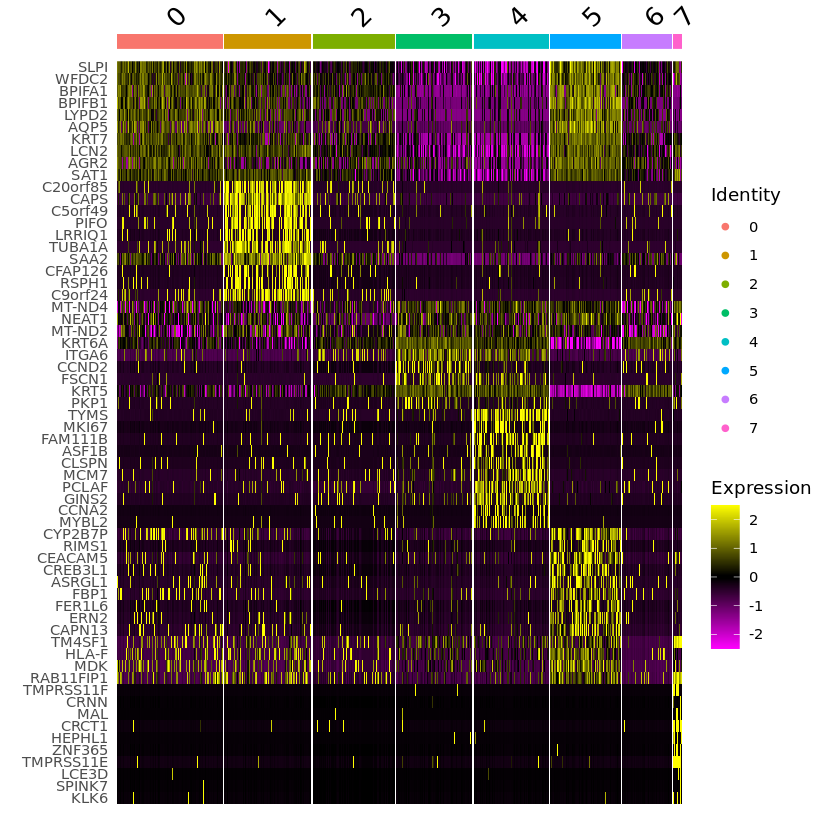

In [186]:
so.markers %>%
    group_by(cluster) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

DoHeatmap(so, features = top10$gene)

In [187]:
library(celldex)
hpca.se <- HumanPrimaryCellAtlasData()

Cannot connect to ExperimentHub server, using 'localHub=TRUE' instead

Using 'localHub=TRUE'
  If offline, please also see BiocManager vignette section on offline use

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



In [188]:
library(SingleR)
pred.so <- SingleR(test = as.SingleCellExperiment(so), ref = hpca.se, clusters = Idents(so),
    labels = hpca.se$label.fine, num.threads = 16 )


Attaching package: 'SingleR'


The following objects are masked from 'package:celldex':

    BlueprintEncodeData, DatabaseImmuneCellExpressionData,
    HumanPrimaryCellAtlasData, ImmGenData, MonacoImmuneData,
    MouseRNAseqData, NovershternHematopoieticData




In [189]:
pred.so$labels

[1] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[3] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[5] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"
[7] "Epithelial_cells:bronchial" "Epithelial_cells:bronchial"

In [191]:
library(rcellmarker)
res <- cellMarker(so.markers,type='seurat',species='human',keytype='SYMBOL',weight=1) #weight for avg_logFC

In [192]:
res

cluster,cellType,Annotated,Significant,Pvalue,Padj,GeneID
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,Secretory cell,91,8,1.017899e-15,3.766225e-14,"BPIFA1,BPIFB1,PI3,VMO1,PIGR,MSMB,SCGB1A1,SCGB3A1"
0,Goblet cell,109,7,1.090579e-12,2.017571e-11,"BPIFB1,AGR2,VMO1,PIGR,MSMB,SCGB1A1,SCGB3A1"
0,Club cell (Clara cell),14,4,3.376640e-10,4.164523e-09,"BPIFB1,MSMB,SCGB1A1,SCGB3A1"
1,Ciliated epithelial cell,436,231,4.509906e-217,1.470229e-214,"C20orf85,LRRIQ1,CFAP126,RSPH1,C9orf24,SNTN,ZMYND10,ROPN1L,CCDC65,RRAD,DRC1,FAM81B,TMEM190,RSPH4A,CAPSL,CCDC170,TUBA4B,SPATA17,WDR38,DYDC2,LRRC10B,EFCAB10,ARMC3,SPAG6,DNAAF1,C7orf57,SPEF1,STOML3,LRRC46,RIBC1,SAXO2,TEKT2,KIF19,IQUB,DTHD1,MLF1,PSENEN,RIIAD1,PACRG,SPA17,DNAH6,EFHB,LRRC23,CCDC78,SPEF2,STMND1,CABCOCO1,AKAP14,TMEM231,ANKRD66,CD164L2,ADGB,KIF9,MORN2,C6orf118,CFAP300,DNAH12,TMC5,CFAP46,UBXN10,LDLRAD1,CFAP299,PIH1D2,ODF3B,SPAG17,NPHP1,EFHC1,CCDC74A,SCGB2A1,FHAD1,RSPH9,SPAG8,NEK10,DNAH7,NEK5,ZBBX,TSNAXIP1,FAM227A,DNAH9,EFHC2,KCNRG,TSPAN19,SYNE1,DNAH11,DNAH10,CDHR3,RIBC2,CFAP43,SPAG1,WDR54,SPATA18,C4orf47,CFAP221,PPP1R42,LRRC71,HYDIN,UBXN11,DZIP3,PRR29,CCDC181,NHLRC4,CCDC74B,CCDC157,IQCD,NWD1,CSPP1,ANKUB1,SLC44A4,IFT57,CFAP44,STK33,CFAP57,DNAI2,CFAP53,B9D1,SAMD15,TTC21A,CFAP69,CFAP47,DNAI1,TMEM67,DNAH5,MRLN,C1orf87,RGS22,CFAP52,C11orf16,USP2,PPP1R36,KIAA2012,GAS2L2,DNAL1,LKAAEAR1,DCDC1,MAP9,TNFRSF19,VWA3B,IL5RA,IFT88,RABL2B,MDH1B,CCDC33,TCTN1,CDHR4,CFAP54,CST6,BASP1,LZTFL1,DCDC2,DZIP1L,KCNE1,CCDC81,LRWD1,MORN3,SPATA4,IFT81,TMEM232,ECT2L,KLHDC9,TTLL7,CCDC13,BAIAP3,SPATA6L,DNAAF4,CCDC148,MS4A8,RBM38,MAPK15,C2orf81,SMPD2,CCDC39,METTL27,VWA3A,FRMPD2,RUVBL1,ZMYND12,ERICH2,AK9,IQCH,ARHGAP18,FBXO15,TOGARAM2,CFAP61,CAPS2,ANKMY1,GAS8,CHST9,P4HTM,DLEC1,TEKT4,WDR19,RABL2A,KIF27,AK8,HHLA2,TTC16,PLEKHS1,DYNC2H1,STX2,PHTF1,KIF3A,CES1,ALDH3B1,DPCD,ANKRD54,CD38,ARMC2,FABP6,TTLL9,SYTL3,KIF6,MDM1,ZNF440,IFT46,KNDC1,CACNG6,AGBL2,CES4A,C20orf96,APH1B,KATNB1,CDS1,CCDC60,MAPRE3,DNAH1,RPGRIP1L,CEP97,ERBB4,BTC,FBXO36,LMLN"
1,Ciliated cell,310,167,1.539416e-153,2.509247e-151,"C20orf85,CAPS,PIFO,LRRIQ1,TUBA1A,SAA2,CFAP126,RSPH1,C9orf24,SNTN,TPPP3,ROPN1L,CCDC65,RRAD,DRC1,AGR3,FAM81B,TMEM190,RSPH4A,CAPSL,CCDC170,TUBA4B,ENKUR,TEKT1,WDR38,LRRC10B,PPIL6,EFCAB10,SPAG6,FOXJ1,C11orf97,STOML3,LRRC46,CTXN1,FAM216B,SAXO2,KIF19,TUBB4B,MLF1,IQCG,PSENEN,RIIAD1,PACRG,CFAP73,SPA17,TSPAN1,LRRC23,WDR86-AS1,STMND1,CABCOCO1,AKAP14,BBOF1,TMEM231,ANKRD66,ZDHHC1,FAM166B,DYNLRB2,IK,KIF9,MORN2,CFAP77,DAW1,DNAH12,EZR,FAM229B,MORN5,CCDC153,PIH1D2,ODF3B,PRDX5,CCDC113,SCGB2A1,LRRC34,DYNLT1,CRIP1,EFHC2,KCNRG,TSPAN19,WDR54,IFT22,NME5,CCDC181,NHLRC4,CCDC74B,CFAP161,APOBEC4,LRRC73,IFT57,CTSS,DNAAF3,CFAP53,UFC1,SAA4,B9D1,SPACA9,CFAP298,CKB,CYSTM1,DNAI1,DNAH5,CETN2,CFAP52,SMIM22,UCP2,VWA3B,CIB1,CCDC33,GPR162,TCTN1,SPAG16,CST6,BASP1,LZTFL1,B9D2,RSPH14,MIA,KCNE1,CCDC81,LRWD1,GON7,HACD4,IQCK,KLHDC9,MAPK8IP1,CYP4B1,PLAC8,ISG20,C2orf81,EPCAM,DYNC2LI1,METTL27,PLEKHB1,TMEM107,RUVBL1,ZMYND12,ERICH2,IQCH,FBXW9,FBXO15,IFT43,CFAP61,HIPK1,ARL3,TPPP,CBY1,CFAP36,STX2,DNAL4,VWA5A,ALDH3B1,DPCD,AZIN1,TSTD1,ANKRD37,NQO1,HS3ST6,IFT46,MYCBP,FUZ,ULK4,BBS9,B3GNT7,BRD3OS,RBKS,CCDC60,MAPRE3,UNC119B"
1,SLC16A7+ cell,1125,79,2.933980e-06,3.188259e-04,"DNAAF1,SPEF2,FILIP1,ADGB,FANK1,DNAH12,TMC5,CFAP46,RP1,SPAG17,EFHC1,DNAH7,ZBBX,FAM227A,SYNE1,DNAH11,CDHR3,C4orf47,CFAP74,CCDC40,CEP126,CFAP44,ORAI2,STK33,MOK,PPOX,NEK11,DZANK1,CFAP100,CFAP69,CFAP47,TMEM67,DNAH5,DNAH3,USP2,MYEF2,DCDC1,CLMN,MDH1B,DZIP1L,ARMH1,CFAP157,JHY,CFAP70,CCDC30,CNTRL,ODF2L,VWA3A,ARMC9,IDO1,ICA1L,TOGARAM2,ANKRD45,CAPS2,FBXL13,COL21A1,PLEKHG7,DLEC1,DNAH2,AKAP9,CLUAP1,DYNC2H1,KANSL1L,MYLK3,SYNGAP1,ZNF440,MACC1,TMEM212,C21orf58,WDR93,SLC4A8,AGBL2,DNAH1,GAS7,SEC14L4,MRNIP,BTBD9,INTU,BAIAP2-DT"
3,Basal cell,127,48,2.659134e-53,7.259436e-51,"KRT6A,ITGA6,CCND2,KRT5,PKP1,SERPINB5,TP63,SERPINB13,SFN,CLCA2,ACKR3,DSG3,KRT17,DST,LAMA3,DSC3,COL17A1,PDPN,TUBB6,LAD1,LYPD3,CDH3,ANXA8,BCAM,ITGB4,FAT2,GPNMB,LGALS7B,LGALS7,CAV1,GPX2,AQP3,ANXA8L1,DUSP7,KRT6C,SNAI2,MMP28,WNT10A,KRT13,KRT16,THBD,LGALS1,LY6D,NOTCH1,KRT15,LOXL4,DAPL

In [193]:
ref_markers = read.delim("../data_dir/markers.tsv", sep = "\t")
str(ref_markers)

'data.frame':	29000 obs. of  7 variables:
 $ clusters    : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ genes       : chr  "RTKN2" "AGER" "CLDN18" "TNNC1" ...
 $ logFC       : num  7.55 8.69 11.7 6.93 7.55 ...
 $ score       : num  5.48 5.48 5.48 5.48 5.48 ...
 $ pvals       : num  4.33e-08 4.33e-08 4.34e-08 4.34e-08 4.34e-08 ...
 $ pvals_adj   : num  5.4e-06 5.4e-06 5.4e-06 5.4e-06 5.4e-06 ...
 $ grch38_genes: chr  "RTKN2" "AGER" "CLDN18" "TNNC1" ...


In [194]:
ref_markers %>%
    group_by(clusters) %>%
    dplyr::filter(pvals_adj < 0.01) %>%
    ungroup() -> filtered_markers

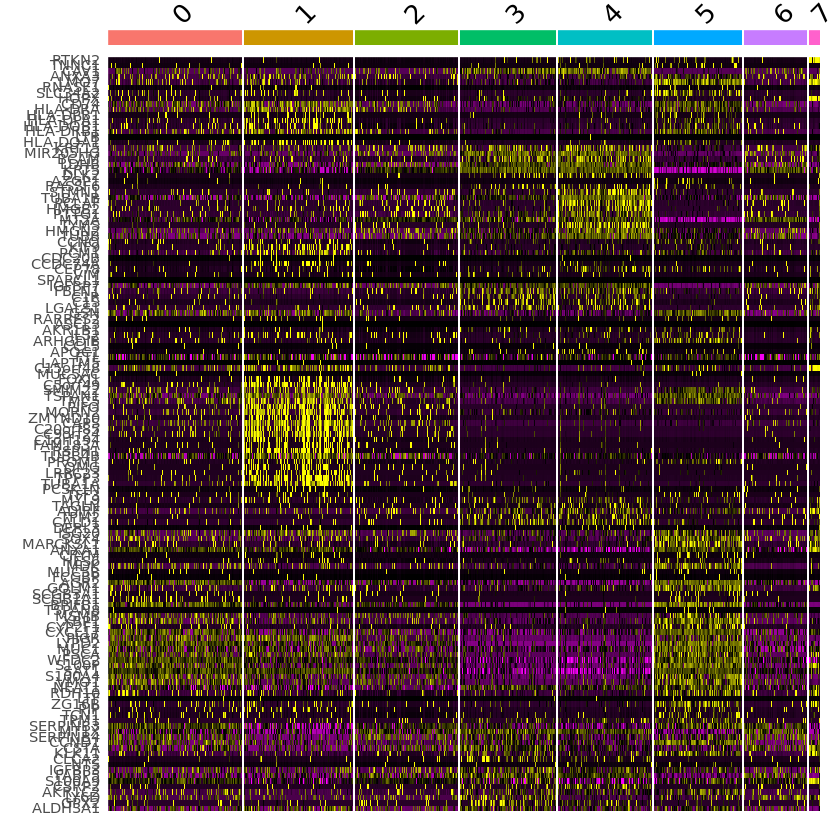

In [195]:
filtered_markers %>%
    group_by(clusters) %>%
    dplyr::filter(logFC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

DoHeatmap(so, features = top10$grch38_genes) + NoLegend()

In [196]:
so.markers %>%
    group_by(cluster) %>%
    dplyr::filter(p_val_adj < 0.01) %>%
    ungroup() -> filtered_so.markers

In [197]:
xscore = function(x,y) {
    genes = intersect(names(x), names(y))
    #y[setdiff(names(x), names(y))] = 0
    #x[setdiff(names(y), names(x))] = 0
    if (length(genes) < 5 ) {
        return(list(estimate = 0, p.value = 1))
    }
    res = cor.test(x[genes], y[genes], method="spearman")
    return(res)
}

mark_annot = NULL
for (cluster in unique(filtered_so.markers$cluster)) {
    for (cell_type in unique(filtered_markers$clusters)){
        idx_x <- filtered_so.markers$cluster == cluster
        idx_y <- filtered_markers$clusters == cell_type
        x <- filtered_so.markers$avg_log2FC[idx_x]
        names(x) <- filtered_so.markers$gene[idx_x]
        y = filtered_markers$logFC[idx_y]
        names(y) = filtered_markers$grch38_genes[idx_y]
        res = xscore(x, y)
        tmp_df = data.frame(
            cluster = cluster,
            cell_type = cell_type,
            pval = res$p.value,
            rho = as.numeric(res$estimate)
        )
        if (is.null(mark_annot)) {
            mark_annot = tmp_df
        } else {
            mark_annot <- rbind(mark_annot, tmp_df)
        }
    }
}


In [207]:
mark_annot %>%
    group_by(cluster) %>%
    dplyr::filter(rho > 0 & pval < 0.001) %>%
    dplyr::arrange(.data$pval) %>%
    slice_head(n = 1) %>%
    ungroup() -> best_annot


In [208]:
str(best_annot)

tibble [6 x 4] (S3: tbl_df/tbl/data.frame)
 $ cluster  : chr [1:6] "0" "1" "3" "4" ...
 $ cell_type: chr [1:6] "Secretory" "Mucous Multiciliated cells" "Basal" "Basal" ...
 $ pval     : num [1:6] 5.3e-05 0.0 0.0 0.0 0.0 ...
 $ rho      : num [1:6] 0.32 0.648 0.582 0.536 0.474 ...


In [210]:
so@meta.data$annot = "?"
cl2annot = best_annot$cell_type
names(cl2annot) <- best_annot$cluster


In [211]:
so@meta.data$annot = cl2annot[as.character(so@meta.data$seurat_clusters)]

In [216]:
tsne_proj = data.frame(so@reductions$tsne@cell.embeddings)
tsne_proj$annot = so@meta.data$annot
str(tsne_proj)

'data.frame':	2167 obs. of  3 variables:
 $ tSNE_1: num  -9.39 6.6 12.28 6.62 -9.74 ...
 $ tSNE_2: num  2.51 -14.03 12.1 -12.67 3.54 ...
 $ annot : chr  "Secretory" NA "Basal" NA ...


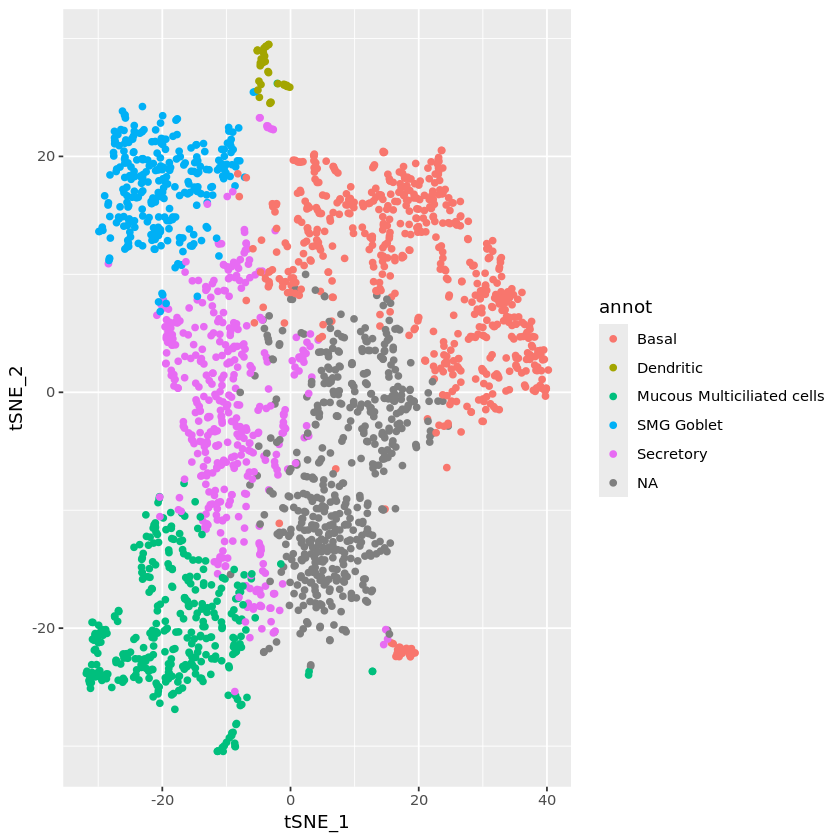

In [217]:
ggplot(tsne_proj, aes(tSNE_1, tSNE_2, color = annot)) +
  geom_point()